Lambda School Data Science

*Unit 2, Sprint 2, Module 3*

---

# Cross-Validation


## Assignment
- [ ] [Review requirements for your portfolio project](https://lambdaschool.github.io/ds/unit2), then submit your dataset.
- [ ] Continue to participate in our Kaggle challenge. 
- [ ] Use scikit-learn for hyperparameter optimization with RandomizedSearchCV.
- [ ] Submit your predictions to our Kaggle competition. (Go to our Kaggle InClass competition webpage. Use the blue **Submit Predictions** button to upload your CSV file. Or you can use the Kaggle API to submit your predictions.)
- [ ] Commit your notebook to your fork of the GitHub repo.


**You can't just copy** from the lesson notebook to this assignment.

- Because the lesson was **regression**, but the assignment is **classification.**
- Because the lesson used [TargetEncoder](https://contrib.scikit-learn.org/categorical-encoding/targetencoder.html), which doesn't work as-is for _multi-class_ classification.

So you will have to adapt the example, which is good real-world practice.

1. Use a model for classification, such as [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)
2. Use hyperparameters that match the classifier, such as `randomforestclassifier__ ...`
3. Use a metric for classification, such as [`scoring='accuracy'`](https://scikit-learn.org/stable/modules/model_evaluation.html#common-cases-predefined-values)
4. If you’re doing a multi-class classification problem — such as whether a waterpump is functional, functional needs repair, or nonfunctional — then use a categorical encoding that works for multi-class classification, such as [OrdinalEncoder](https://contrib.scikit-learn.org/categorical-encoding/ordinal.html) (not [TargetEncoder](https://contrib.scikit-learn.org/categorical-encoding/targetencoder.html))



## Stretch Goals

### Reading
- Jake VanderPlas, [Python Data Science Handbook, Chapter 5.3](https://jakevdp.github.io/PythonDataScienceHandbook/05.03-hyperparameters-and-model-validation.html), Hyperparameters and Model Validation
- Jake VanderPlas, [Statistics for Hackers](https://speakerdeck.com/jakevdp/statistics-for-hackers?slide=107)
- Ron Zacharski, [A Programmer's Guide to Data Mining, Chapter 5](http://guidetodatamining.com/chapter5/), 10-fold cross validation
- Sebastian Raschka, [A Basic Pipeline and Grid Search Setup](https://github.com/rasbt/python-machine-learning-book/blob/master/code/bonus/svm_iris_pipeline_and_gridsearch.ipynb)
- Peter Worcester, [A Comparison of Grid Search and Randomized Search Using Scikit Learn](https://blog.usejournal.com/a-comparison-of-grid-search-and-randomized-search-using-scikit-learn-29823179bc85)

### Doing
- Add your own stretch goals!
- Try other [categorical encodings](https://contrib.scikit-learn.org/categorical-encoding/). See the previous assignment notebook for details.
- In additon to `RandomizedSearchCV`, scikit-learn has [`GridSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html). Another library called scikit-optimize has [`BayesSearchCV`](https://scikit-optimize.github.io/notebooks/sklearn-gridsearchcv-replacement.html). Experiment with these alternatives.
- _[Introduction to Machine Learning with Python](http://shop.oreilly.com/product/0636920030515.do)_ discusses options for "Grid-Searching Which Model To Use" in Chapter 6:

> You can even go further in combining GridSearchCV and Pipeline: it is also possible to search over the actual steps being performed in the pipeline (say whether to use StandardScaler or MinMaxScaler). This leads to an even bigger search space and should be considered carefully. Trying all possible solutions is usually not a viable machine learning strategy. However, here is an example comparing a RandomForestClassifier and an SVC ...

The example is shown in [the accompanying notebook](https://github.com/amueller/introduction_to_ml_with_python/blob/master/06-algorithm-chains-and-pipelines.ipynb), code cells 35-37. Could you apply this concept to your own pipelines?


### BONUS: Stacking!

Here's some code you can use to "stack" multiple submissions, which is another form of ensembling:

```python
import pandas as pd

# Filenames of your submissions you want to ensemble
files = ['submission-01.csv', 'submission-02.csv', 'submission-03.csv']

target = 'status_group'
submissions = (pd.read_csv(file)[[target]] for file in files)
ensemble = pd.concat(submissions, axis='columns')
majority_vote = ensemble.mode(axis='columns')[0]

sample_submission = pd.read_csv('sample_submission.csv')
submission = sample_submission.copy()
submission[target] = majority_vote
submission.to_csv('my-ultimate-ensemble-submission.csv', index=False)
```

In [1]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [2]:
import pandas as pd

# Merge train_features.csv & train_labels.csv
train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))

# Read test_features.csv & sample_submission.csv
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

In [37]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
import numpy as np
import pandas as pd
import category_encoders as ce
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from scipy.stats import uniform

def feature_finding(X):
    X = X.copy()
    X['latitude'] = X['latitude'].replace(-2e-08,0)
    bad = ['id','recorded_by','quantity_group','payment_type','source_type']
    X = X.drop(columns=bad)
    cols_with_zeros = ['longitude','latitude','construction_year',
                       'gps_height','population']
    for cols in cols_with_zeros:
        X[cols] = X[cols].replace(0, np.nan)
        X[cols+'_MISSING'] = X[cols].isnull()
    X['date_recorded'] = pd.to_datetime(X['date_recorded'], infer_datetime_format=True)
    X['year_recorded'] = X['date_recorded'].dt.year
    X = X.drop(columns='date_recorded')
    X['years'] = X['year_recorded'] - X['construction_year']
    X['years_MISSING'] = X['years'].isnull()
    return X


In [4]:
train, val = train_test_split(train, train_size=.8, test_size=.2,
                             stratify=train['status_group'], random_state=1)
train.shape, val.shape, test.shape

((47520, 41), (11880, 41), (14358, 40))

In [5]:
train = feature_finding(train) 
val = feature_finding(val)
test = feature_finding(test)

In [6]:
train.shape, val.shape, test.shape


((47520, 43), (11880, 43), (14358, 42))

In [7]:
target = 'status_group'
X_train = train.drop(columns=[target])
y_train = train[target]
X_val = val.drop(columns=[target])
y_val = val[target]
X_test = test

In [8]:
from sklearn.model_selection import cross_val_score

pipeline = make_pipeline(ce.OrdinalEncoder(),
                        SimpleImputer(strategy='median'),
                        RandomForestClassifier(random_state=1, n_jobs=-1))
k = 5
scores = cross_val_score(pipeline, X_train, y_train, cv=k,
                        scoring='accuracy')
print(f'Accuracy for {k} folds:', scores)

Accuracy for 5 folds: [0.80397727 0.80934343 0.80071549 0.79713805 0.80418771]


In [9]:
pipeline.fit(X_train, y_train)
print('Validation Accuracy:', pipeline.score(X_val, y_val))

Validation Accuracy: 0.8066498316498316


In [10]:
columns = X_train.columns.to_list()
columns

['amount_tsh',
 'funder',
 'gps_height',
 'installer',
 'longitude',
 'latitude',
 'wpt_name',
 'num_private',
 'basin',
 'subvillage',
 'region',
 'region_code',
 'district_code',
 'lga',
 'ward',
 'population',
 'public_meeting',
 'scheme_management',
 'scheme_name',
 'permit',
 'construction_year',
 'extraction_type',
 'extraction_type_group',
 'extraction_type_class',
 'management',
 'management_group',
 'payment',
 'water_quality',
 'quality_group',
 'quantity',
 'source',
 'source_class',
 'waterpoint_type',
 'waterpoint_type_group',
 'longitude_MISSING',
 'latitude_MISSING',
 'construction_year_MISSING',
 'gps_height_MISSING',
 'population_MISSING',
 'year_recorded',
 'years',
 'years_MISSING']

In [13]:
X_train['years'].isnull().sum()

16496

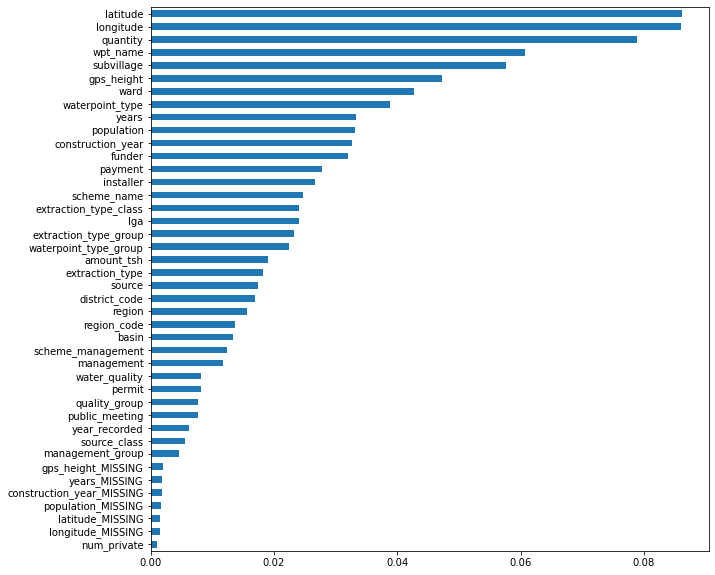

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline
model = pipeline.named_steps['randomforestclassifier']
encoder = pipeline.named_steps['ordinalencoder']
encoded_columns = encoder.transform(X_val).columns
importances = pd.Series(model.feature_importances_, encoded_columns)
plt.figure(figsize=(10,10))
importances.sort_values().plot.barh()

In [33]:
notwanted = ['num_private','longitude_MISSING','latitude_MISSING','population_MISSING',
             'construction_year_MISSING','gps_height_MISSING','years_MISSING']
X_train2 = train.drop(columns=notwanted)
X_train2 = X_train2.drop(columns=target)
y_train2 = train[target]
X_val2 = val.drop(columns=notwanted)
X_val2 = X_val2.drop(columns=target)
y_val2 = val[target]
X_test2 = test.drop(columns=notwanted)
columns2 = X_train2.columns.to_list()
columns2

['amount_tsh',
 'funder',
 'gps_height',
 'installer',
 'longitude',
 'latitude',
 'wpt_name',
 'basin',
 'subvillage',
 'region',
 'region_code',
 'district_code',
 'lga',
 'ward',
 'population',
 'public_meeting',
 'scheme_management',
 'scheme_name',
 'permit',
 'construction_year',
 'extraction_type',
 'extraction_type_group',
 'extraction_type_class',
 'management',
 'management_group',
 'payment',
 'water_quality',
 'quality_group',
 'quantity',
 'source',
 'source_class',
 'waterpoint_type',
 'waterpoint_type_group',
 'year_recorded',
 'years']

In [34]:
pipe2 = make_pipeline(ce.OrdinalEncoder(),
                        SimpleImputer(strategy='median'),
                        RandomForestClassifier(random_state=1, n_jobs=-1))
k = 5
scores = cross_val_score(pipe2, X_train2, y_train2, cv=k,
                        scoring='accuracy')
print(f'Accuracy for {k} folds:', scores)

Accuracy for 5 folds: [0.7996633  0.81323653 0.8013468  0.79345539 0.80050505]


In [35]:
pipe2.fit(X_train2, y_train2)
print('Validation Accuracy:', pipe2.score(X_val2, y_val2))

Validation Accuracy: 0.8046296296296296


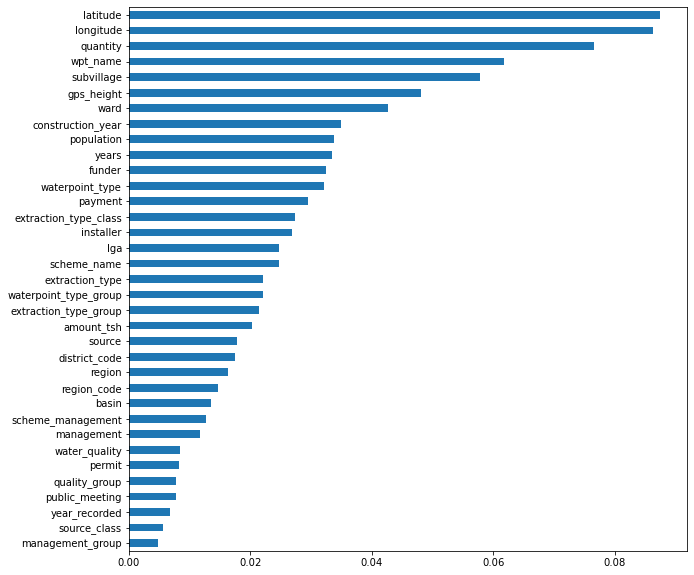

In [36]:
model2 = pipe2.named_steps['randomforestclassifier']
encoder2 = pipe2.named_steps['ordinalencoder']
encoded_columns2 = encoder2.transform(X_val2).columns
importances2 = pd.Series(model2.feature_importances_, encoded_columns2)
plt.figure(figsize=(10,10))
importances2.sort_values().plot.barh()

Hm. Dropping a bunch of columns drops like a small percentage. Might as well go back to pipeline.


In [45]:
#pipeline
param = {'randomforestclassifier__n_estimators': range(50,500),
      'randomforestclassifier__max_depth':[5,10,15,20, None],
      'randomforestclassifier__max_features': uniform(0,1),
      'randomforestclassifier__min_samples_leaf': [1,10,100],}

randomized = RandomizedSearchCV(pipeline, param_distributions= param,
                                n_iter=50, cv=5, scoring='accuracy',
                                verbose=10, return_train_score=True,
                                n_jobs=-1)
randomized.fit(X_train, y_train)


Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   25.1s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   32.5s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:  8.0min
[Parallel(n_jobs=-1)]: Done 121 tasks      | elapsed:  9.1min
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed: 11.1min
[Parallel(n_jobs=-1)]: Done 157 tasks      | elapsed: 13.0min
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed: 14.0min
[Parallel(n_jobs=-1)]: Done 197 tasks      | elapsed: 1

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('ordinalencoder',
                                              OrdinalEncoder(cols=['funder',
                                                                   'installer',
                                                                   'wpt_name',
                                                                   'basin',
                                                                   'subvillage',
                                                                   'region',
                                                                   'lga',
                                                                   'ward',
                                                                   'public_meeting',
                                                                   'scheme_management',
                                                                   'scheme_name',
                                     

In [46]:
#Investigat this error later- estimator.get_params().keys()
y_pred = randomized.predict(X_test)
y_pred.shape

(14358,)

In [47]:
print('Validation Accuracy:',randomized.score(X_val,y_val))

Validation Accuracy: 0.8090909090909091


In [49]:
submission = sample_submission.copy()
submission['status_group'] = y_pred
submission.to_csv('robbennettrandomizedforest.csv', index=False)